In [1]:
!nvidia-smi

Thu Jun 16 02:05:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[Auto-Reload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html)

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
from fastai.text import *

## Sample data 1000

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll **begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.**

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

NameError: ignored

It only contains one csv file, let's have a look at it.

In [ ]:
df = pd.read_csv(path/'texts.csv')
df.shape

In [ ]:
df.head()

In [ ]:
df['text'][1]

It contains one line per review, with the label ('negative' or 'positive'), **the text and a flag to determine if it should be part of the validation set or the training set**. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [ ]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. 

**A `TextDataBunch` does all of that behind the scenes for you.**

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [ ]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [ ]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [ ]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [ ]:
data.vocab.itos[:10]

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [ ]:
data.train_ds[0][0]

But the underlying data is all numbers

In [ ]:
data.train_ds[0][0].data[:10]

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Target task LM fine-tuning Full Dataset

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [7]:
# Batch Size 
bs = 48

Now let's grab the full dataset for what follows.

In [8]:
# TMP: tempt data not label, we only focus folder train, test & unsup
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab')]

In [9]:
# 25000 Data Train with Label Pos & Neg
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat')]

The data follows an ImageNet-style organization, in the train folder, we have two subfolders, `pos` and `neg` (for positive reviews and negative reviews). We can gather it by using the `TextDataLoaders.from_folder` method. The only thing we need to specify is the name of the validation folder, which is "test" (and not the default "valid").

In [ ]:
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
dls.show_batch()

We can see that the library automatically processed all the texts to split then in *tokens*, adding some special tokens like:

- `xxbos` to indicate the beginning of a text
- `xxmaj` to indicate the next word was capitalized


We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a **model pretrained on a bigger dataset - AWDLSTM** (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a **recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.**

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [10]:
data_lm = (TextList.from_folder(path)
           # Inputs: all the text files in path
            .filter_by_folder(include = ['train', 'test', 'unsup']) 
           # We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           # We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           # We want to do a language model so we label accordingly
            .databunch(bs=bs))
           # Batch size 
# Save Data API 
data_lm.save('data_lm.pkl')

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [11]:
# Load Data API
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [12]:
data_lm.show_batch()

idx,text
0,"share in common : the generally accepted running time of 90 - 120 minutes , with a minority of movies that dare to approach , but rarely exceed , the three - hour mark . \n \n xxmaj for this reason , a film like xxmaj out 1 ( runtime : xxunk minutes ) is a challenge for even the most hardened cinephile , and it goes some way"
1,"xxmaj frodo has found it increasingly difficult to get away from that major role . xxmaj playing a football hooligan , a psychopath and now a young xxmaj jewish xxmaj american , xxmaj wood has tried any route he can to escape this typecasting . xxmaj now , with "" xxmaj everything xxmaj is xxmaj illuminated "" he might finally have achieved this . xxmaj playing a role which is"
2,", she rightfully describes herself as a virgin ( further credit to xxmaj brigitte 's thespian skills that she can handle the line so convincingly , being after all one of the more active adult actresses of the ' 70s ) because she can not recall a single touch preceding his . xxmaj because of this nifty bit of context , the relatively long sex scene that follows totally eschews"
3,"video versions . xxmaj if you enjoy older ' 70s slasher - horror films , "" xxmaj tourist xxmaj trap "" is an underrated retro gem . 8 / 10 . xxbos xxmaj this movie is a picture perfect action / drama / and thriller , every scene has you sucked in . i watched this movie and was amazed by how many talented actors were in the movie ."
4,"matter , set the style here of acting being the focus of the story and the directing . xxmaj it 's perhaps a new innovative hybrid of improv meets indie film - making . xxbos i do love xxup b- horror films . i however , am generally not a huge fan of "" so stupid it 's funny "" films . i xxup had to rate this so highly"


**General-domain LM pretraining**


An ImageNet-like corpus for language should be large and capture general properties of language. We pretrain the language model on Wikitext-103 (Merity et al., 2017b) consisting of 28,595 prepro- cessed Wikipedia articles and 103 million words. Pretraining is most beneficial for tasks with small datasets and enables generalization even with 100 labeled examples. We leave the exploration of more diverse pretraining corpora to future work, but expect that they would boost performance. While this stage is the most expensive, it only needs to be performed once and improves perfor- mance and convergence of downstream models.


We can then put this in a **learner object very easily with a model loaded with the pretrained weights**.

[Learner](https://docs.fast.ai/text.learner.html)

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

[callbacks.lr_finder](https://fastai1.fast.ai/callbacks.lr_finder.html)

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


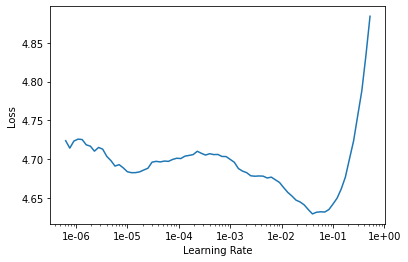

In [15]:
learn.recorder.plot(skip_end=15)

[callbacks.one_cycle](https://fastai1.fast.ai/callbacks.one_cycle.html)

In [16]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.170908,4.021296,0.295505,51:20


In [17]:
# Model fit_head
learn.save('fit_head')

In [18]:
learn.load('fit_head');

[Why do we need to unfreeze the learner everytime before retraining even if learn.fit_one_cycle() works fine without learn.unfreeze()?](https://forums.fast.ai/t/why-do-we-need-to-unfreeze-the-learner-everytime-before-retarining-even-if-learn-fit-one-cycle-works-fine-without-learn-unfreeze/41614)


To complete the fine-tuning, we can then unfeeze and launch a new training.

In [19]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.862192,3.809823,0.318066,58:56


epoch,train_loss,valid_loss,accuracy,time
0,3.862192,3.809823,0.318066,58:56


In [ ]:
# Model fine_tuned
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We have to save not only the model, but also its **encoder, the part that's responsible for creating and updating the hidden state**. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Target task classifier fine-tuning

Now, we'll create a new data object that only **grabs the labelled data and keeps those labels**. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)

In [ ]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             # grab all the text files in path
             .split_by_folder(valid='test')
             # split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             # label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [ ]:
data_clas.show_batch()

We can then create a **model to classify those reviews and load the encoder we saved before**

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [ ]:
# Finding Learning Rate 
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [ ]:
# Save First Classifier
learn.save('first')
# Load Model 1
learn.load('first')

[Freeze Fast.ai](https://www.kaggle.com/code/danielliao/understanding-learner-freeze-to/notebook)
```Python
def freeze_to(self, n:int)->None:
    for g in self.layer_groups[:n]: freeze 
    for g in self.layer_groups[n:]: unfreeze
````

In [ ]:
# Freeze Layer, Freeze (0 to excecpt 2 last layers)
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
# Model 2
learn.save('second')
# Load Model 2 
learn.load('second')

In [ ]:
# Freeze Layer, Freeze (0 to excecpt 3 last layers)
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
# Model 3
learn.save('third')
# Load Model 3 
learn.load('third')

In [ ]:
# Unfreeze all layers 
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")